In [1]:
# Import standard modules
using Plots
using Distributions
using LinearAlgebra
using Random
rng_seed = 44

# Import ensemble Kalman process modules
import EnsembleKalmanProcesses
const EKP = EnsembleKalmanProcesses

# Import CLIMA parameter modules
import CLIMAParameters
const CP =  CLIMAParameters
struct EarthParameterSet <: CP.AbstractEarthParameterSet end
const param_set = EarthParameterSet()

# Import aerosol activation modules
import CloudMicrophysics
const AM = CloudMicrophysics.AerosolModel
const AA = CloudMicrophysics.AerosolActivation

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1342
┌ Info: Precompiling EnsembleKalmanProcesses [aa8a2aa5-91d8-4396-bcef-d4f2ec43552d]
└ @ Base loading.jl:1342
┌ Info: Precompiling CloudMicrophysics [6a9e3e04-43cd-43ba-94b9-e8782df3c71b]
└ @ Base loading.jl:1342


CloudMicrophysics.AerosolActivation

In [3]:
# Define the parameters we want to learn
parameter_names = ["molar_mass", "osmotic_coeff"]

# This is a perfect model setting test so we actually know the parameter values.
# We will use it to test the convergence of EKP for aerosol activation.
molar_mass_true = 0.058443
osmotic_coeff_true = 0.9
default_params = [molar_mass_true, osmotic_coeff_true]

# Define constraints (values have to be positive)
c1 = EKP.ParameterDistributionStorage.bounded_below(0.0)
c2 = EKP.ParameterDistributionStorage.bounded_below(0.0)
constraints = [[c1], [c2]]

# Define the assumed prior parameter distribution
d1 = EKP.ParameterDistributionStorage.Parameterized(Distributions.Normal(0,1))
d2 = EKP.ParameterDistributionStorage.Parameterized(Distributions.Normal(0,1))
distributions = [d1, d2]

# Define the priors
priors = EKP.ParameterDistributionStorage.ParameterDistribution(distributions, constraints, parameter_names);

In [4]:
# Define the atmospheric conditions.
# This can be changed later to include more than one (T,p,w) combination in the calibartion process
T = 283.15     # air temperature in K
p = 100000.0   # air pressure in Pa
w = 5.0        # vertical velocity in m/s

# Define the aerosol size distribution (lognormal, 1 mode)
r_dry = 0.243 * 1e-6 # mean radius in m
stdev = 1.4          # geometric stdev
N = 100.0 * 1e6      # number concentration 1/m3

# Define the aerosol properties (sea salt)
dissoc_seasalt = 2.0
soluble_mass_frac_seasalt = 1.0
rho_seasalt = 2170.0;

In [5]:
# Define a wrapper function that runs the aerosol activation module
# with two input parameters that will be calibrated by EKP.
# The output observations are the number and mass of activated aerosol.
function run_activation_model(molar_mass_calibrated, osmotic_coeff_calibrated)

    accum_mode_seasalt = AM.Mode_B(
        r_dry,
        stdev,
        N,
        (1.0,),
        (soluble_mass_frac_seasalt,),
        (osmotic_coeff_calibrated,),
        (molar_mass_calibrated,),
        (dissoc_seasalt,),
        (rho_seasalt,),
        1,
    )
    
    aerosol_distr = AM.AerosolDistribution((accum_mode_seasalt,))
    N_act = AA.total_N_activated(param_set, aerosol_distr, T, p, w)
    M_act = AA.total_M_activated(param_set, aerosol_distr, T, p, w)
    return [N_act, M_act]
end

observation_data_names = ["N_act", "M_act"];

In [6]:
# Generate artificial truth samples based on the default values 
# of parameters we are calibrating ...
n_samples = 10
G_t = run_activation_model(molar_mass_true, osmotic_coeff_true)
y_t = zeros(length(G_t), n_samples)

Γy = convert(Array, LinearAlgebra.Diagonal([0.01 * G_t[1], 0.01 * G_t[2]]))
μ = zeros(length(G_t));

# ... with some added noise
for i in 1:n_samples
    y_t[:, i] = G_t .+ rand(Distributions.MvNormal(μ, Γy))
end

truth_array = EKP.Observations.Obs(y_t, Γy, observation_data_names)

# One could try for the truth to be a mean of the generated array.
# Or do the calibration for all individual truth samples and then
# compute the mean of calibrated parameters.
# For now we are just taking one truth array member 
truth_sample = truth_array.samples[1];

In [7]:
N_ens = 50 # number of ensemble members
N_iter = 10 # number of EKI iterations

initial_par = EKP.EnsembleKalmanProcessModule.construct_initial_ensemble(
    priors,
    N_ens;
    rng_seed
)
ekiobj = EKP.EnsembleKalmanProcessModule.EnsembleKalmanProcess(
    initial_par,
    truth_sample,
    truth_array.obs_noise_cov, EKP.EnsembleKalmanProcessModule.Inversion(),
    Δt=1
)

# Run the Ensemble Kalman Process calibration
ϕ_n_values = []
for n in 1:N_iter
    θ_n = EKP.EnsembleKalmanProcessModule.get_u_final(ekiobj)
    
    # Transform parameters to physical/constrained space
    ϕ_n = mapslices(
        x -> EKP.ParameterDistributionStorage.transform_unconstrained_to_constrained(priors, x),
        θ_n;
        dims=1
    )

    #for i in 1:N_ens
    #    println("iter: ", i, " trying parameter values: ", ϕ_n[:, i])
    #end
    
    G_n = [run_activation_model(ϕ_n[:, i]...) for i in 1:N_ens]

    #for i in 1:N_ens
    #    println("iter: ", i, " and getting observations: ", G_n[i, :])
    #end

    G_ens = hcat(G_n...)  # reformat
    EKP.EnsembleKalmanProcessModule.update_ensemble!(ekiobj, G_ens)

    ϕ_n_values = vcat(ϕ_n_values, [ϕ_n])
end

In [8]:
# Define some functions for plotting

function plot_ensemble_scatter(id)

    ensemble_member = range(1, N_ens, length=N_ens)
    
    ylabel = "TODO"
    if id == 1
        ylabel = "Molar mass [kg/mol]"
    end
    if id == 2
        ylabel = "Osmotic coefficient [-]"
    end
        
    plot(ensemble_member, ϕ_n_values[1][id,1:N_ens],
          seriestype=:scatter, xlabel="Ensemble Number", ylabel=ylabel, leg=false
         )
    for it in range(2, N_iter, length=N_iter-1)
        it = Int(it)
        plot!(ensemble_member.+((it-1)*50), ϕ_n_values[it][id, 1:N_ens], seriestype=:scatter, leg=false)
    end
    
    current()
end

function plot_ensemble_means(id)
    
    number_of_iters = range(1, N_iter, length=N_iter)
    means = zeros(N_iter)
    
    for it in range(1, N_iter, length=N_iter)
        it = Int(it)
        means[it] = mean(ϕ_n_values[it][id,1:N_ens])
    end

    ylabel = "TODO"
    if id == 1
        ylabel = "Molar mass [kg/mol]"
    end
    if id == 2
        ylabel = "Osmotic coefficient [-]"
    end
    
    plot(number_of_iters, means, xlabel = "ensemble number", ylabel = ylabel, label = "enseble mean")
    hline!([default_params[id]], label="true value")
end;

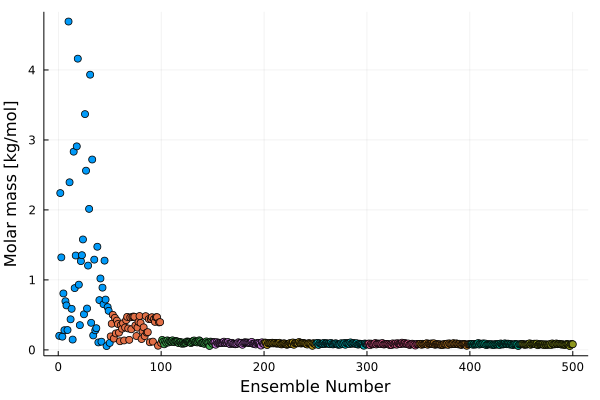

In [9]:
plot_ensemble_scatter(1)

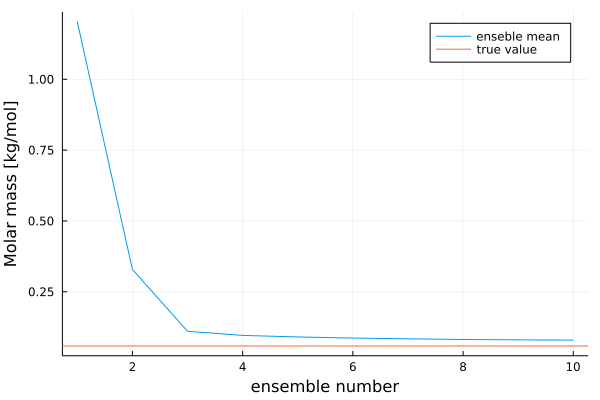

In [10]:
plot_ensemble_means(1)

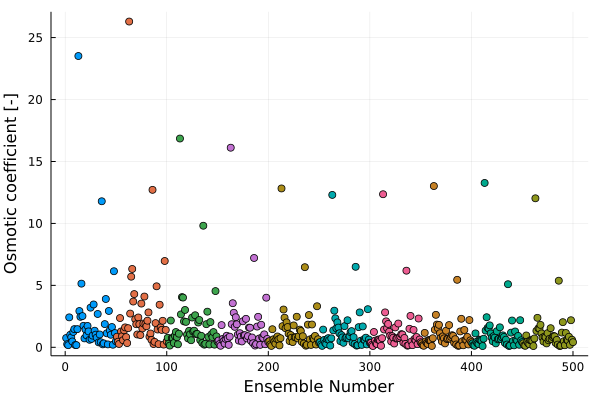

In [11]:
plot_ensemble_scatter(2)

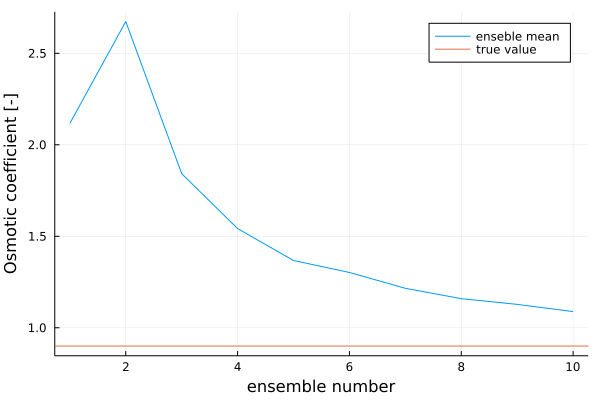

In [12]:
plot_ensemble_means(2)